MOCPy introduction
--------------------

MOCPy is a python library for creating, manipulate and parse MOCs (Multi-Order Coverage maps).
A MOC describes any arbitrary region on the sky. MOCs can be used to:

- Represent the spatial footprint of a catalog (source and/or image survey).
- Compare the footprints, perform fast intersections, unions, differences.
- Filter an astropy table by discarding all the sources that do not lie in the MOC region.

MOCPy's code can be found on GitHub: https://github.com/cds-astro/mocpy
You can install it: `pip install mocpy`

MOCPy's documentation: https://cds-astro.github.io/mocpy/

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import mocpy
from astropy.coordinates import Angle, SkyCoord
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astroquery.mocserver import MOCServer
from astroquery.vizier import Vizier
from ipyaladin import Aladin
from matplotlib import patheffects
from mocpy import WCS
from regions import CircleSkyRegion

mocpy.__version__

'0.14.0'

## Use astroquery.cds to get spatial footprints (MOCs)
----------------------------------------------------------------------

MOCs can be retrieved from ``astroquery.cds``. ``astroquery.cds`` offers a Python access API  to the MOCServer that stores ~20000 metadata and MOCs of Vizier catalogues and ~500 metadata and MOCs of HiPS image surveys.

``astroquery.cds`` documentation https://astroquery.readthedocs.io/en/latest/cds/cds.html#getting-started

-----------
Let's retrieve:

- The MOC representing the footprint of all the HST combined surveys (see the astroquery.cds documentation, an example is given about that) at the order 8 (i.e. the precision of the MOC, ~13 arcmin)
- The MOC representing the footprint of SDSS9: ID='CDS/P/SDSS9/color'

In [2]:
# HST MOC footprint
# -----------------
# We want to retrieve all the HST surveys i.e. the HST surveys covering any region of the sky.
allsky = CircleSkyRegion(SkyCoord(0, 0, unit="deg"), Angle(180, unit="deg"))
hst_moc = MOCServer.query_region(
    region=allsky,
    # We want a MOCpy object instead of an astropy table
    return_moc=True,
    # The order of the MOC
    max_norder=11,
    # Expression on the ID meta-data
    meta_data="ID=*HST*",
)

# SDSS9
# -----
sdss_moc = MOCServer.find_datasets(
    meta_data="ID=CDS/P/SDSS9/color",
    return_moc=True,
    max_norder=11,
)

In [3]:
type(sdss_moc)

mocpy.moc.moc.MOC

## Manipulate MOCs using MOCPy
---------------------------------------------

``astroquery.cds`` returns mocpy.MOC typed objects. Use MOCPy (see the API of the mocpy.MOC class https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC) to manipulate them, for example you could:

- Compute their intersection/union
- Serialize them to FITS/json, save them to FITS files
- Filter an astropy table to keep only the sources being on a MOC (the intersection between sdss and the hst surveys).

In [4]:
%%time
sdss_and_hst_moc = sdss_moc.intersection(hst_moc)
sdss_moc.serialize(format="fits")
sdss_moc.save("sdss_moc.fits", format="fits", overwrite=True)

CPU times: user 10.4 ms, sys: 3.53 ms, total: 13.9 ms
Wall time: 13.3 ms


## Plot a MOC using matplotlib
----------------------------------------

Let's see how to plot a MOC using matplotlib.
There is an example of that on the MOCPy's documentation: https://cds-astro.github.io/mocpy/examples/examples.html#loading-and-plotting-the-moc-of-sdss

----------
We use ``matplotlib`` and``MOCPy`` to draw the MOCs of HST and SDSS that we downloaded from `astroquery.cds`.

MOCPy offers an interface to create a WCS:

- centered around a SkyCoord position
- with a specific field of view 
- and a projection (follows this link to see all the projection supported : https://docs.astropy.org/en/stable/wcs/#supported-projections)

MOCPy offers 2 methods taking a ``matplotlib.axe.Axe`` and drawing into it either:

- the full area of the MOC (``mocpy.MOC.fill``)
- only its perimeter (``mocpy.MOC.border``)

These methods accept additional stylistic kwargs defined by ``matplotlib``: https://matplotlib.org/api/_as_gen/matplotlib.patches.PathPatch.html#matplotlib.patches.PathPatch

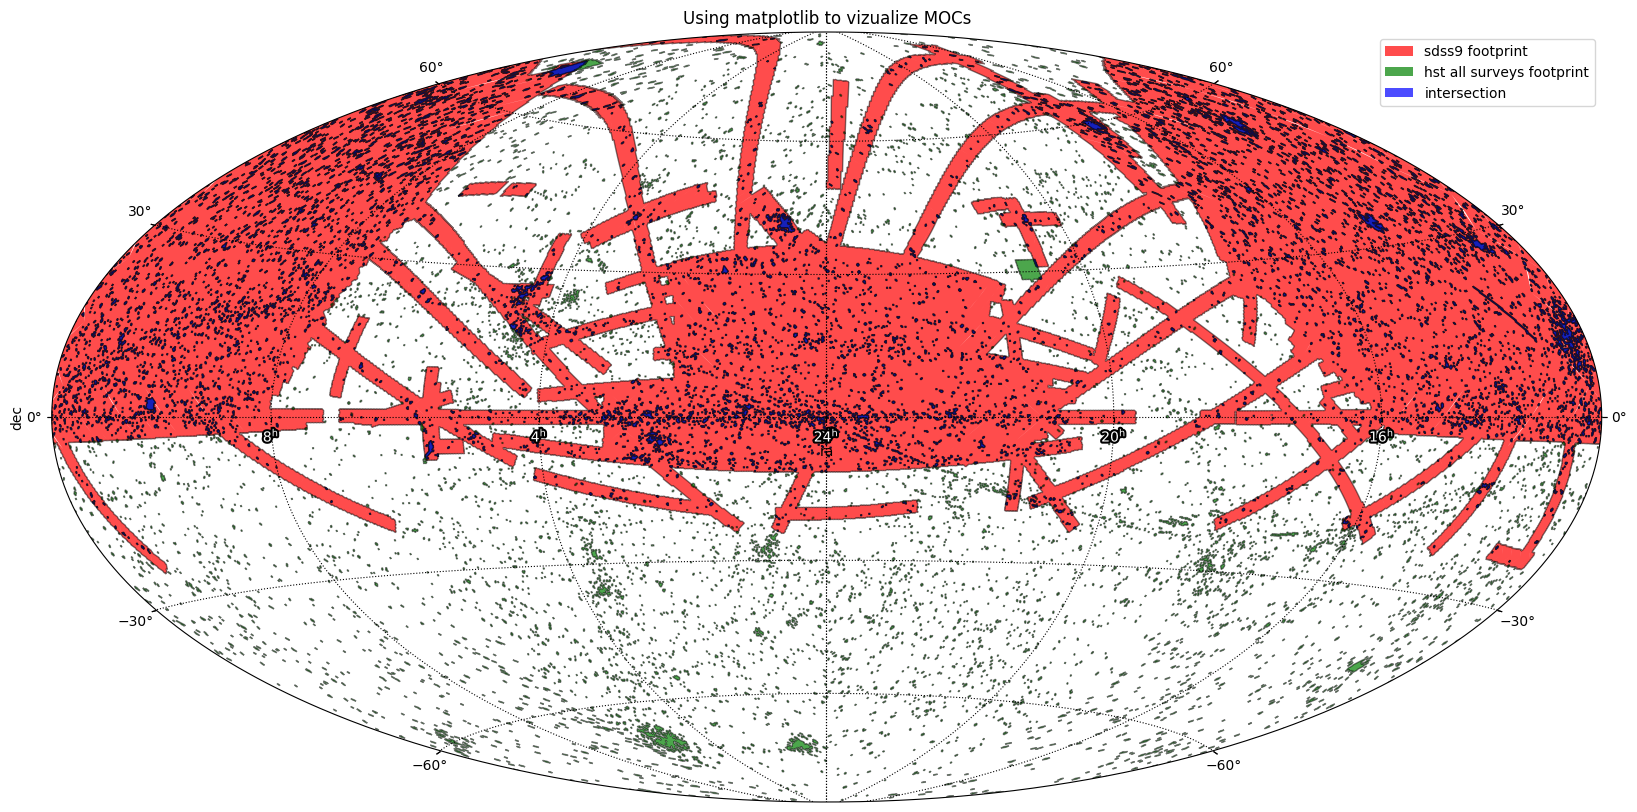

In [5]:
fig = plt.figure(figsize=(20, 10))

with WCS(
    fig,
    fov=160 * u.deg,
    center=SkyCoord(0, 0, unit="deg", frame="icrs"),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    projection="AIT",
) as wcs:
    # Create a matplotlib axe and give it a astropy.wcs.WCS-like object
    ax = fig.add_subplot(1, 1, 1, projection=wcs, frame_class=EllipticalFrame)

    # Fill the SDSS MOC in red with an opacity of 70%
    sdss_moc.fill(
        ax=ax,
        wcs=wcs,
        edgecolor="r",
        facecolor="r",
        linewidth=0,
        fill=True,
        alpha=0.7,
        label="sdss9 footprint",
    )
    # Draw its perimeter in black
    sdss_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)

    # Fill the HST surveys MOC in green with an opacity of 70%
    hst_moc.fill(
        ax=ax,
        wcs=wcs,
        edgecolor="g",
        facecolor="g",
        linewidth=0,
        fill=True,
        alpha=0.7,
        label="hst all surveys footprint",
    )
    # Draw its perimeter in black
    hst_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)

    # Fill the intersection MOC in blue
    sdss_and_hst_moc.fill(
        ax=ax,
        wcs=wcs,
        edgecolor="b",
        facecolor="b",
        linewidth=0,
        fill=True,
        alpha=0.7,
        label="intersection",
    )
    # Draw its perimeter in black
    sdss_and_hst_moc.border(ax=ax, wcs=wcs, color="black", alpha=0.5)

# Usual matplotlib calls
plt.title("Using matplotlib to vizualize MOCs")
plt.xlabel("ra")
plt.ylabel("dec")
plt.legend()
plt.grid(color="black", linestyle="dotted")
path_effects = [patheffects.withStroke(linewidth=3, foreground="black")]
ax.coords[0].set_ticklabel(color="white", path_effects=path_effects)
plt.show()
plt.close()

## Filter an astropy.Table by a MOC
---------------------------------------------
 
1. Retrieve a catalog table from Vizier (e.g. II/50). Add the columns '_RAJ2000' and '_DEJ2000' to the outputs. MOCPy needs the positions for filtering the table.
2. Filter the table to get only the sources that lie into intersection MOC.

In [6]:
viz = Vizier(columns=["*", "_RAJ2000", "_DEJ2000"])
viz.ROW_LIMIT = -1
# Photometric standard stars (tables II and IV of paper)
tables = viz.get_catalogs("II/50")
tables

TableList with 1 tables:
	'0:II/50/ubv' with 20 column(s) and 2036 row(s) 

In [7]:
table_II50 = tables[0]
table_II50

_RAJ2000,_DEJ2000,HD,m_HD,Vmag,u_Vmag,e_Vmag,w_Vmag,B-V,u_B-V,e_B-V,w_B-V,U-B,u_U-B,w_U-B,S,Notes,Simbad,_RA,_DE
deg,deg,,,mag,,mag,,mag,,mag,,mag,,,,,,deg,deg
float64,float64,int32,str1,float32,str1,float32,float32,float32,str1,float32,float32,float32,str1,float32,str1,str23,str6,float64,float64
1.3339206,-5.7076183,28,,4.615,,0.007,5.20,1.040,,0.007,5.50,0.89,,2.50,,,Simbad,1.33392,-5.70762
2.3526750,-45.7474261,496,,3.875,,0.005,2.50,1.020,,0.010,2.70,0.86,,1.00,C,,Simbad,2.35267,-45.74743
3.6600664,-18.9328656,1038,,4.430,),0.018,3.50,1.655,,0.006,3.70,2.00,:,3.00,*,,Simbad,3.66007,-18.93287
4.8569769,-8.8239214,1522,,3.550,),0.016,6.20,1.220,),0.014,6.20,1.20,:,4.50,*,,Simbad,4.85698,-8.82392
5.0177506,-64.8747906,1581,,4.220,,--,1.50,0.575,,--,1.50,0.01,,1.00,C,,Simbad,5.01775,-64.87479
6.4377994,-77.2542456,2151,,2.800,,0.006,2.50,0.625,,0.005,1.70,0.10,,1.00,C,,Simbad,6.43780,-77.25425
6.5710456,-42.3059814,2261,,2.395,,0.013,3.50,1.085,,0.004,3.20,0.89,,1.00,C,,Simbad,6.57105,-42.30598
6.5508408,-43.6798294,2262,,3.940,,0.013,2.50,0.170,,0.008,2.70,0.11,,1.00,C,,Simbad,6.55084,-43.67983


In [8]:
idx_inside = sdss_and_hst_moc.contains_lonlat(
    table_II50["_RAJ2000"].T * u.deg,
    table_II50["_DEJ2000"].T * u.deg,
)
sources_inside = table_II50[idx_inside]
sources_outside = table_II50[~idx_inside]
sources_inside

_RAJ2000,_DEJ2000,HD,m_HD,Vmag,u_Vmag,e_Vmag,w_Vmag,B-V,u_B-V,e_B-V,w_B-V,U-B,u_U-B,w_U-B,S,Notes,Simbad,_RA,_DE
deg,deg,,,mag,,mag,,mag,,mag,,mag,,,,,,deg,deg
float64,float64,int32,str1,float32,str1,float32,float32,float32,str1,float32,float32,float32,str1,float32,str1,str23,str6,float64,float64
34.8366364,-2.9776425,14386,,--,),--,--,1.600,,--,0.70,--,,--,,,Simbad,34.83664,-2.97764
49.8404000,3.3701978,20630,,4.845,,0.011,9.70,0.680,,0.006,9.20,0.20,,5.75,,,Simbad,49.84040,3.37020
83.8465175,-4.8383578,37018,,4.590,,0.009,4.00,-0.200,,0.004,4.00,-0.93,,3.50,,,Simbad,83.84652,-4.83836
83.8159267,-5.3873150,37020,/,4.580,:,--,--,0.050,:,--,--,-0.86,:,--,,the1 Ori,Simbad,83.81593,-5.38731
100.2444194,9.8957542,47839,,4.655,,0.008,5.00,-0.245,,0.005,4.00,-1.07,,4.00,,,Simbad,100.24442,9.89575
126.4151344,-3.9064236,71155,,3.900,,0.007,6.50,-0.015,,0.006,6.00,-0.02,,4.50,,,Simbad,126.41513,-3.90642
158.2027994,9.3065856,91316,,3.855,,0.007,7.50,-0.140,,0.010,6.50,-0.96,,4.50,,,Simbad,158.20280,9.30659
169.1654206,-3.6516011,98058,,4.465,,0.004,3.00,0.210,,0.005,3.00,0.13,,3.50,*,,Simbad,169.16542,-3.65160


## Run Aladin-Lite inside a jupyter notebook: ipyaladin
-----------------------------------------------------------------------

Aladin-Lite can be embedded into a jupyter notebook: Follow the readme on GitHub for installing it: https://github.com/cds-astro/ipyaladin

In [9]:
aladin = Aladin()
aladin

In [10]:
aladin.target = "messier 51"
aladin.fov = 1
aladin.height = 600

In [11]:
aladin.coo_frame = "icrs"

Change the image survey, go to https://aladin.unistra.fr/hips/list (Part 1. HiPS sky maps) to test with different image surveys! A list of good HiPS I like for testing:
- P/2MASS/color
- P/PanSTARRS/DR1/color-z-zg-g
- P/SPITZER/color
- P/SDSS9/color
- P/GALEXGR6/AIS/color
- P/Mellinger/color

In [12]:
aladin.survey = "P/SDSS9/color"

Add a MOC in the aladin-lite view!

In [13]:
aladin.add_moc(
    sdss_and_hst_moc,
    color="blue",
    opacity=0.3,
    fill=True,
    edge=False,
    perimeter=True,
)

In [14]:
# Add astropy source tables to the aladin lite viewer
aladin.add_table(sources_inside, color="green", shape="rhomb")
aladin.add_table(sources_outside, color="red", shape="cross")

In [15]:
# change the fov and target
aladin.target = "13 04 4.193 -03 34 13.54"
aladin.fov = 11

-------

Useful links
-------------

More info about MOCs:

- It relies on the HEALPix tesselation of the sphere: paper link https://iopscience.iop.org/article/10.1086/427976/fulltext/
- HEALPix implementation in the cdshealpix (`pip install cdshealpix`) https://github.com/cds-astro/cds-healpix-python
- The IVOA reference paper about MOC: http://ivoa.net/documents/MOC/20190903/PR-MOC-1.1-20190903.pdf

Time-MOCs and recently Space-Time MOCs:

- ADASS 2019 presentation from Pierre Fernique: https://www.adass2019.nl/wp-content/uploads/adass-oral/O2-3-fernique-stmoc-behind-the-scene.pdf
- IVOA notebook about ST-MOCs in MOCPy: https://github.com/cds-astro/mocpy/blob/master/notebooks/Space%20%26%20Time%20coverages.ipynb